### Dataset used 

- ADaM_Metadata&ADEF (28rows)

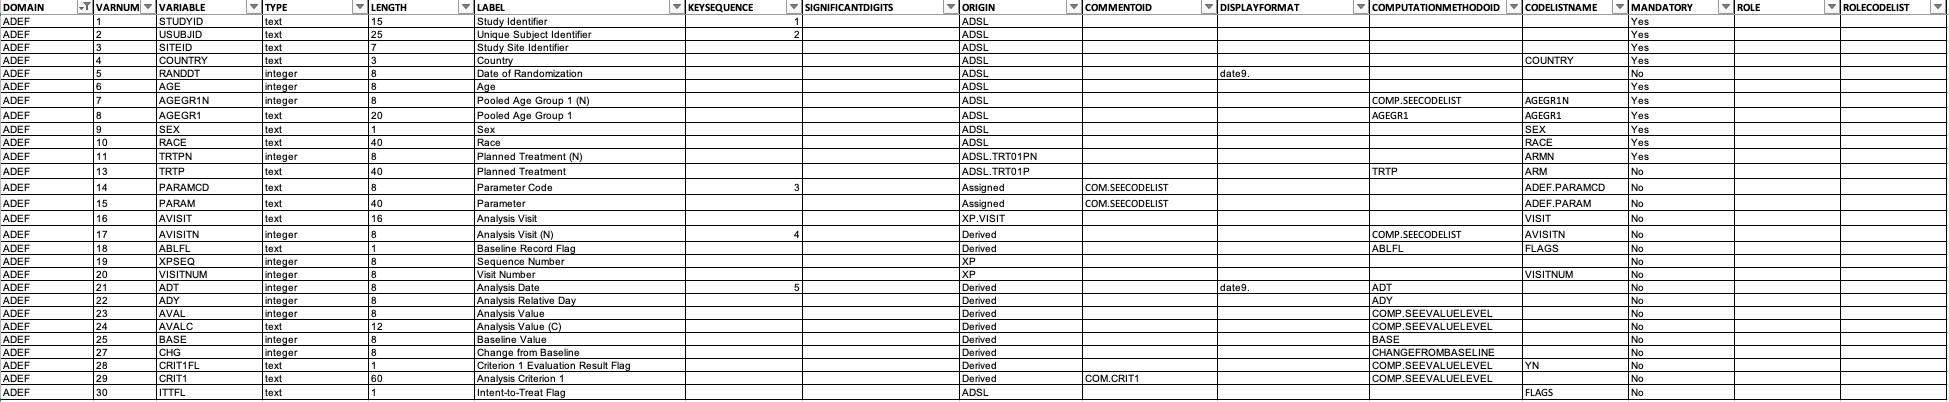

- STDM.xp (177rows, 15cols)

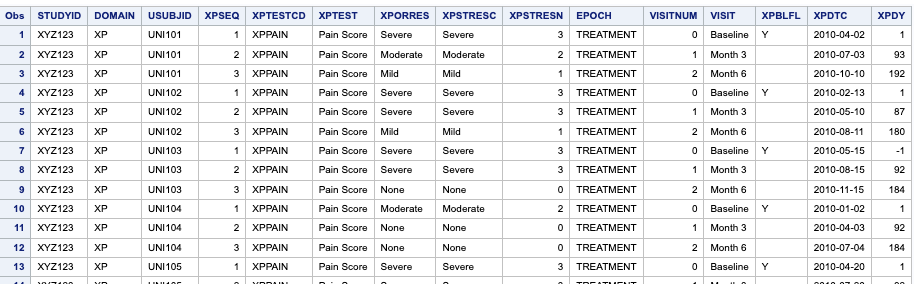

- adam.adsl (60rows, 24 cols)

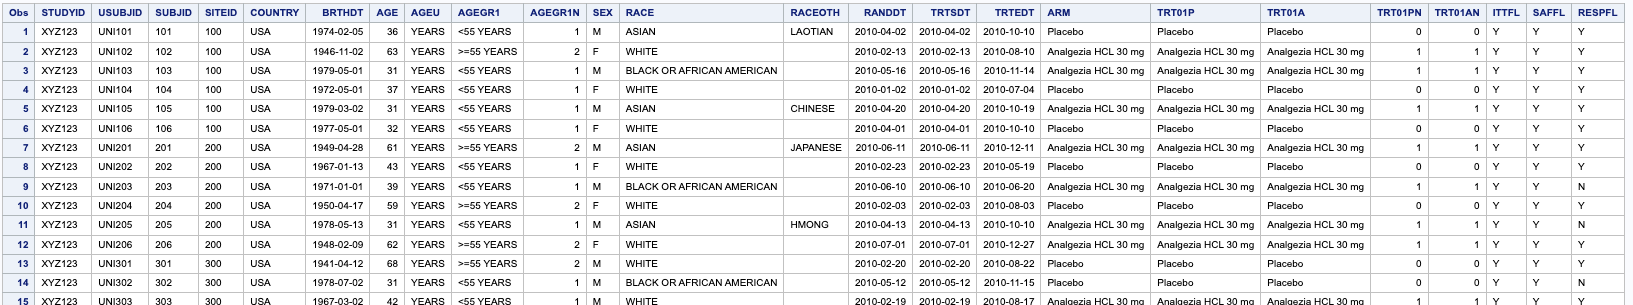


### Step 1: make empty dataset (EMPTY_ADEF) 

In [ ]:
/*---------------------------------------------------------------*;
* ADEF.sas creates the ADaM BDS-structured data set for efficacy data (ADEF), saved to the ADaM libref.
*---------------------------------------------------------------*/

%include "/home/junmeng0/02-Implementing CDISC Using SAS/chapter07/setup.sas";


**** CREATE EMPTY ADEF DATASET CALLED EMPTY_ADEF;
options mprint ;
%let metadatafile=/home/junmeng0/02-Implementing CDISC Using SAS/chapter07/ADAM_METADATA.xls;

%make_empty_dataset(metadatafile=&metadatafile,dataset=ADEF);


### Step 2: Load ans filter ADAM.ADSL, only keep interested columns, save as adsl

In [ ]:
proc sort
  data = adam.adsl
  (keep = usubjid siteid country age agegr1 agegr1n sex race randdt trt01p trt01pn ittfl)
  out = adsl;
    by usubjid;

### Step 3: Create `adef` dataset by merge `sdtm.xp` and `adsl`
- merge two dataset by key usubjid
- rename some variables and derive new variables

In [ ]:
data adef;
  merge sdtm.xp (in = inadef) adsl (in = inadsl);
    by usubjid ;
    
        if not(inadsl and inadef) then
          put 'PROB' 'LEM: Missing subject?-- ' usubjid= inadef= inadsl= ;
        
        rename trt01p    = trtp
               trt01pn   = trtpn
               xptest    = param
               xptestcd  = paramcd
               visit     = avisit
               xporres   = avalc
        ;               
        if inadsl and inadef;
        avisitn = input(put(visitnum, avisitn.), best.);
        
        %dtc2dt(xpdtc, refdt=randdt);
run;

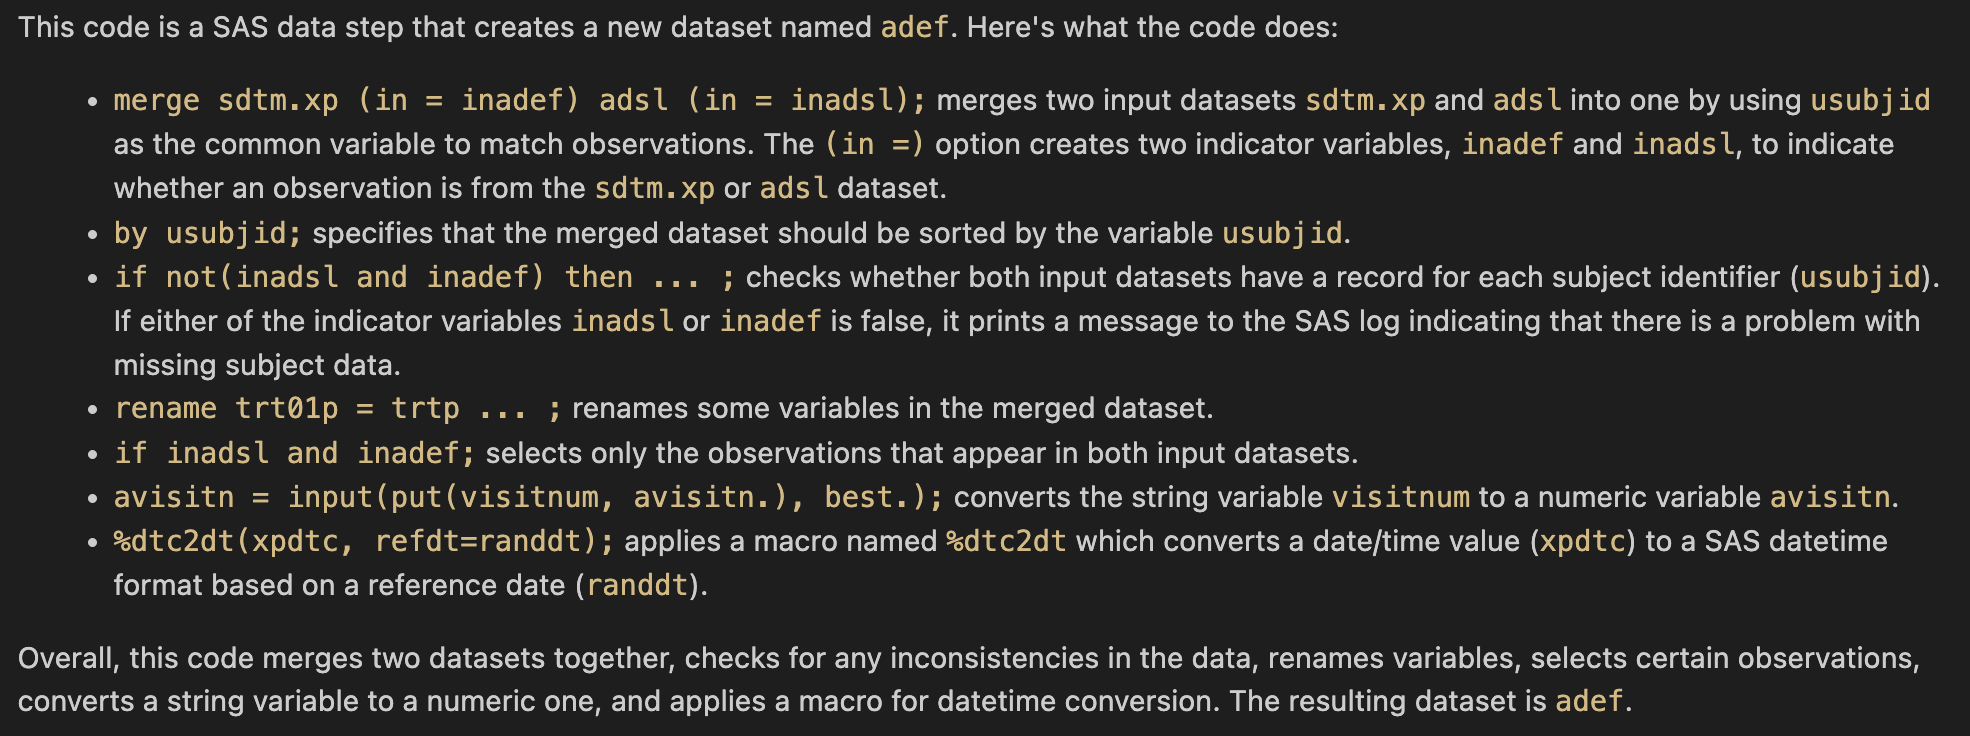

### Step 4. Calculate changes from baseline for all post-baseline visits
- adef dataset, filter ady(Analysis relative Day) <=1 & aval(analysis value) is missing or nonpositive
- create base1 with usubjid visitnum
- create base2 with usubjid base

In [ ]:
** calculate changes from baseline for all post-baseline visits;
%cfb(indata=adef, outdata=adef, dayvar=ady, avalvar=xpstresn);

In [ ]:
/*---------------------------------------------------------
* Macro for deriving ABLFL, BASE, CHG, and PCHG for a BDS formatted ADaM data set;

* Assumes baseline is the last non-missing value on or before study day 1 and that the INDDATA is an SDTM data set with
  variables USUBJID and VISITNUM
*---------------------------------------------------------;*/ 
%macro cfb(indata= ,outdata= ,avalvar= ,dayvar= ,keepvars= );

    proc sort
      data = &indata
      out = &outdata (rename = (&avalvar = aval));
        by usubjid visitnum;
    run;
    
    * Baseline is defined as the last non-missing value prior to study day 1 first dose;
    * (note, values on Day 1 are assumed to occur before the first dose);
    data base1 (keep = usubjid visitnum) base2 (keep = usubjid base);
      set &outdata;
        where &dayvar<=1 and aval > .z; 
        by usubjid visitnum;
        
        rename aval = base;
        if last.usubjid;
    run;        
    
    * Do one merge to identify the baseline record;
    data &outdata;
      merge &outdata base1 (in = inbase);
        by usubjid visitnum;

           if inbase then 
             ablfl = 'Y';
    run;
                 
    * Do another merge to merge in the baseline value;                 
    data &outdata;
      merge &outdata base2;
        by usubjid;
    
           %if &keepvars^= %then
             keep  &keepvars;
           ;
           
           if base > .z then
             chg  = aval - base;
           if base>.z and base ne 0 then
             pchg = chg/base*100;
    run;
    
%mend cfb;

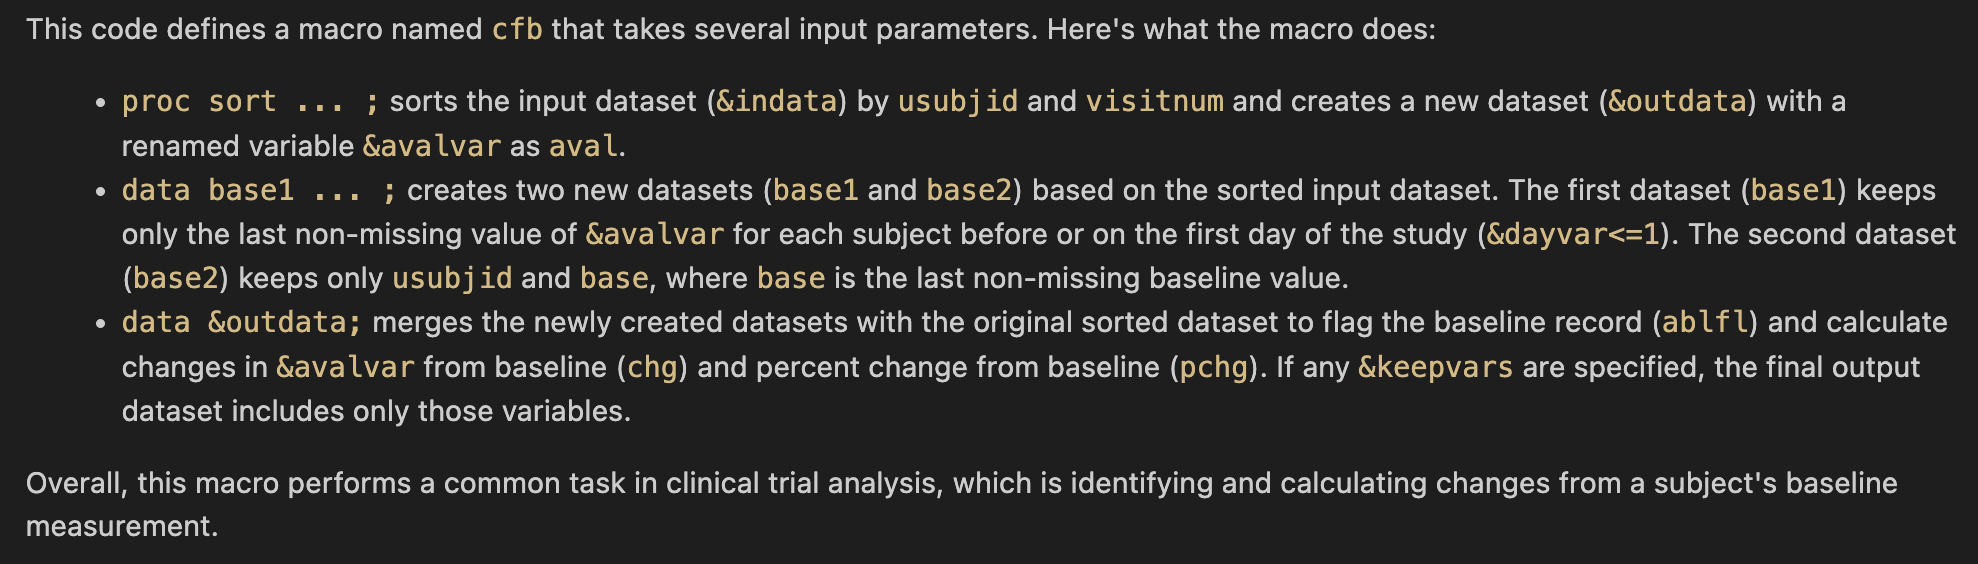

### Step 5: update the adef dataset with data manipulation
- adds two variables `RESPFL` and `crit1fl` to the original `adef`
- add variable labels and retains the order of variables

In [ ]:
data adef;
  set adef;
    by usubjid;
            
        retain crit1 "Pain improvement from baseline of at least 2 points";
        RESPFL = put((.z <= chg <= -2), _0n1y.);         
        if RESPFL='Y' then
          crit1fl = 'Y';
        else
          crit1fl = 'N';          
run;

** assign variable order and labels;
data adef;
  retain &ADEFKEEPSTRING;
  set EMPTY_ADEF adef;
run;

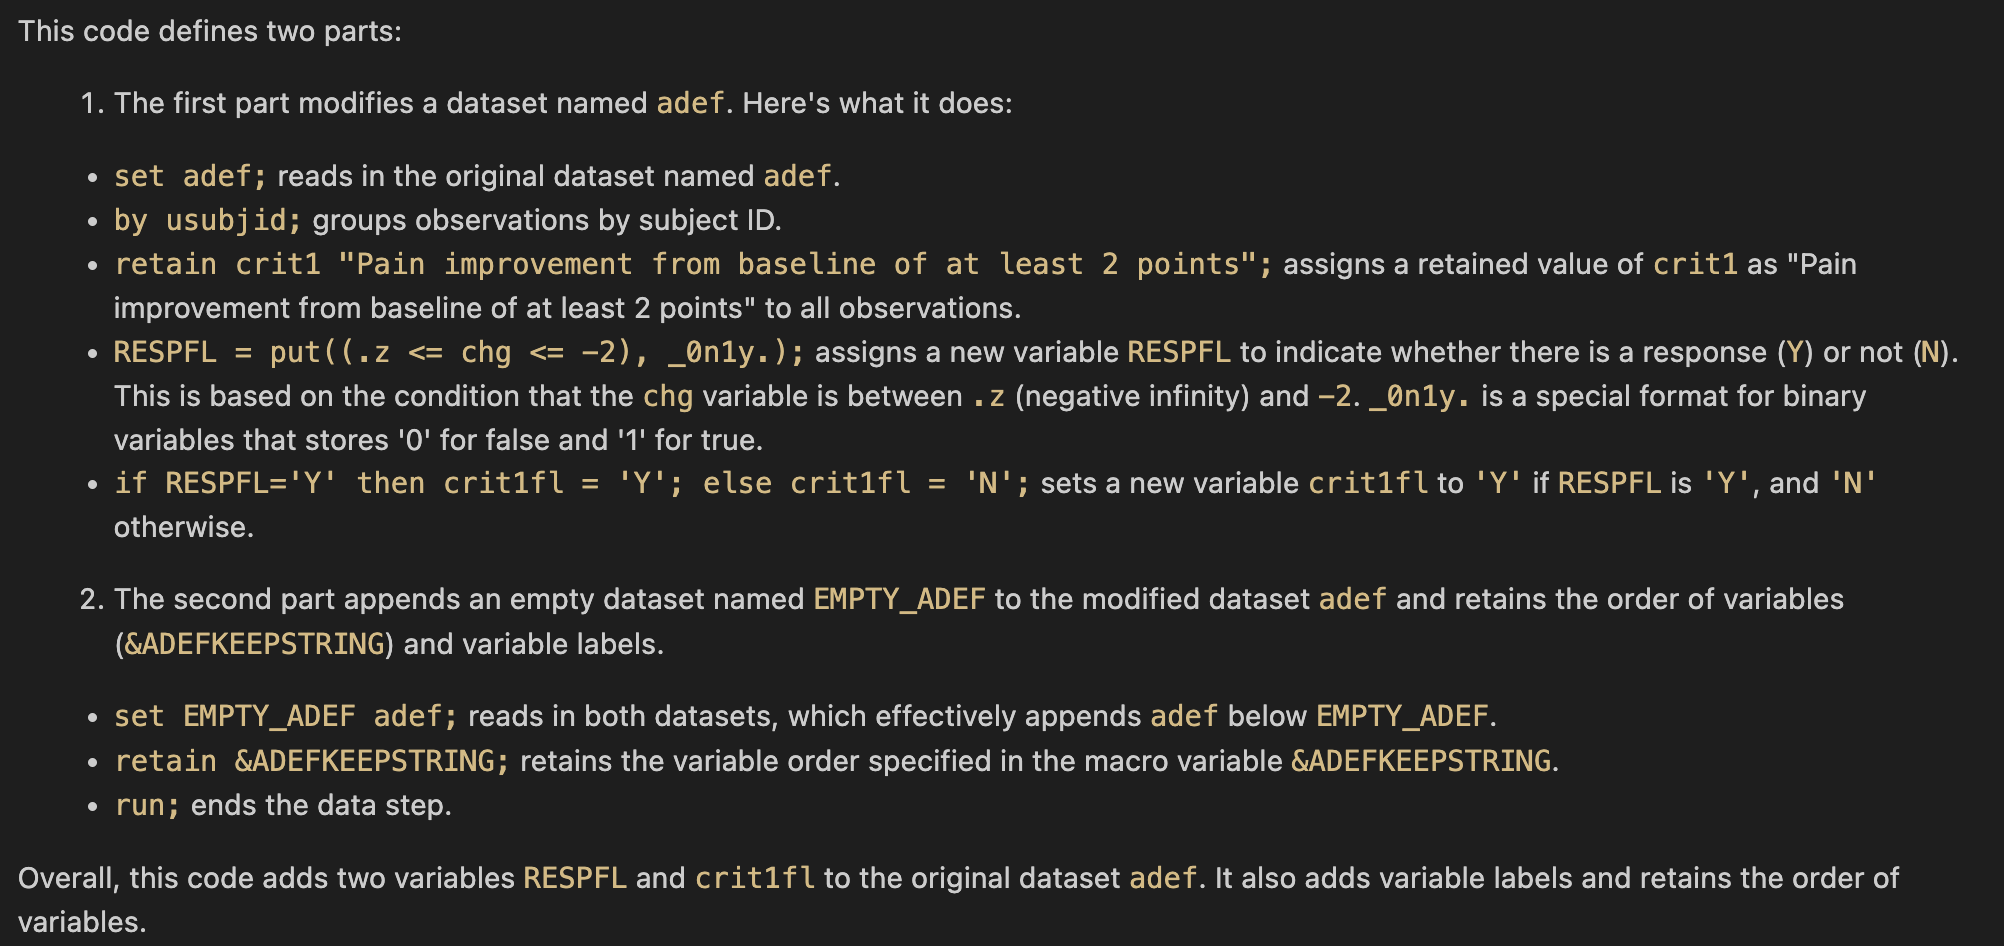

### Step 6: keep &KEEPSTRING and sort ADEF to metadata and save permanent dataset

In [ ]:
**** SORT ADEF ACCORDING TO METADATA AND SAVE PERMANENT DATASET;
%make_sort_order(metadatafile=&metadatafile,dataset=ADEF);

proc sort
  data=adef(keep = &ADEFKEEPSTRING)
  out=adam.adef;
    by &ADEFSORTSTRING;
run;        
